# Can luminosity distribution explain FRB flux distribution?

## First, model luminosity distribution

In [10]:
%matplotlib inline

In [17]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo

In [12]:
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm

In [13]:
lum = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39
lum.sort()

In [77]:
cnt = np.arange(1,len(lum)+1)[::-1]
plaw = lambda ll, alpha, a: a*(ll/ll[0])**alpha
popt, pcov = curve_fit(plaw, lum, cnt, p0=(-1, 10))

[-0.55949284  9.68028818]


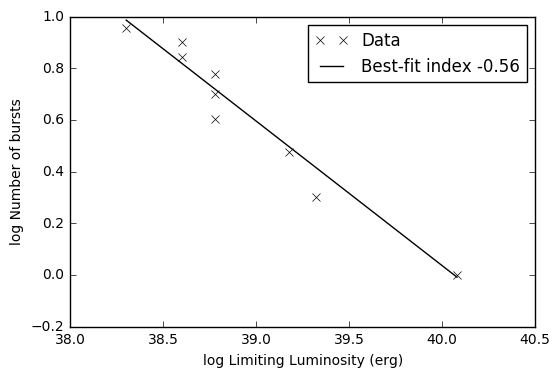

In [78]:
print(popt)
pl.plot(np.log10(lum), np.log10(cnt), 'kx', label='Data')
pl.plot(np.log10(lum), np.log10(plaw(lum, *popt)), '-k', label='Best-fit index {0:.2f}'.format(popt[0]))
pl.xlabel('log Limiting Luminosity (erg)')
pl.ylabel('log Number of bursts')
pl.legend()

## Simulate population

In [79]:
co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

In [109]:
z_min, z_max = 0.1, 1.0
l_min, l_max = 1e35, 1e45
lumsim = np.logspace(np.log10(l_min), np.log10(l_max), 100)

In [127]:
zs = np.random.uniform(z_min, z_max, size=10000)
vols = np.array([co.comoving_volume(z).value for z in zs])

In [128]:
fluxes = []
rate = plaw(lumsim, *popt)
for i in range(100):
    z = np.random.choice(zs, p=vols/vols.sum())  # choose redshift with probablility scaling by volume
    flux = lumsim/(4*np.pi*co.luminosity_distance(z).value**2)
    ff = np.random.choice(flux, p=rate/rate.sum())  # choose flux with probability scaling by rate
    fluxes.append(ff)
fluxes = np.array(fluxes)
fluxes.sort()

In [129]:
cnt2 = np.arange(1,len(fluxes)+1)[::-1]
popt2, pcov2 = curve_fit(plaw, fluxes, cnt2, p0=(-1, 1e-3))

/Users/caseyjlaw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


[  -0.42827064  105.24084084]


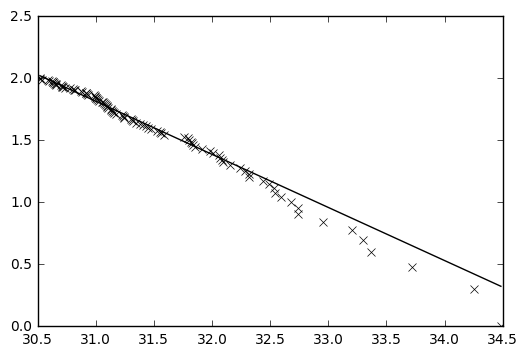

In [130]:
print(popt2)
pl.plot(np.log10(fluxes), np.log10(cnt2), 'kx', label='Data')
pl.plot(np.log10(fluxes), np.log10(plaw(fluxes, *popt2)), '-k', label='Best-fit index {0:.2f}'.format(popt[0]))